# Potato Anomaly Detection and Classification
Ce notebook implémente : 
1. Détection d’anomalies (AE)
2. Classification multi‐classe (Multi‐seuils / KMeans)
3. Comparaison méthodes classiques

In [1]:
!pip install numpy matplotlib tensorflow scikit-learn umap-learn
!pip install --upgrade numpy
!pip install --upgrade numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 58.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
try:
    import umap.umap_ as umap
except ModuleNotFoundError:
    umap = None
from tensorflow.keras.callbacks import EarlyStopping

2025-04-20 18:22:28.150103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 18:22:28.155687: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-20 18:22:28.167019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745173348.182206    8746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745173348.186514    8746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745173348.200802    8746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
# Définir le chemin du dataset
DATA_DIR = "./potato_data"
print("Classes disponibles :", os.listdir(DATA_DIR))

Classes disponibles : ['Pink Rot', 'Black Scurf', 'Healthy Potatoes', 'Miscellaneous', 'Dry Rot', 'Blackleg', 'Common Scab']


In [6]:
# Fonction de chargement d'images
from tensorflow.keras.preprocessing import image

def load_images_from_folder(folder, image_size=(128,128)):
    images = []
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        try:
            img = image.load_img(img_path, target_size=image_size)
            arr = image.img_to_array(img) / 255.0
            images.append(arr)
        except:
            continue
    return np.array(images)

In [7]:
# Charger images normales pour l'AE
normal_dir = os.path.join(DATA_DIR, 'Healthy Potatoes')
normal_images = load_images_from_folder(normal_dir)
print('Images normales :', normal_images.shape)

Images normales : (80, 128, 128, 3)


In [8]:
# Construire l'autoencodeur
def build_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)
    # Decoder
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(input_shape[2], 3, activation='sigmoid', padding='same')(x)
    autoencoder = models.Model(inputs, decoded)
    return autoencoder

input_shape = normal_images.shape[1:]
ae = build_autoencoder(input_shape)
ae.compile(optimizer='adam', loss='mse')
ae.summary()

2025-04-20 18:23:52.379946: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

# --- Entraînement de l'autoencodeur ---
EPOCHS = 30
BATCH_SIZE = 32
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = ae.fit(
    normal_images, normal_images,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30


2025-04-20 18:23:58.639614: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-04-20 18:23:58.799276: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-04-20 18:23:58.886813: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1612

2025-04-20 18:23:59.302448: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-04-20 18:23:59.392845: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.1485 - val_loss: 0.0943
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step - loss: 0.0776 - val_loss: 0.0603
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step - loss: 0.0479 - val_loss: 0.0772
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - loss: 0.0578 - val_loss: 0.0727
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step - loss: 0.0512 - val_loss: 0.0603
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step - loss: 0.0448 - val_loss: 0.0560
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - loss: 0.0431 - val_loss: 0.0492
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step - loss: 0.0373 - val_loss: 0.0471
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step - loss: 0.0346 - val_loss: 0.0408
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 764ms/step - loss: 0.0289 - val_loss: 0.0320
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - loss: 0.0245 - val_loss: 0.0293
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - loss: 0.0220 - val_loss: 0.0248
Epo

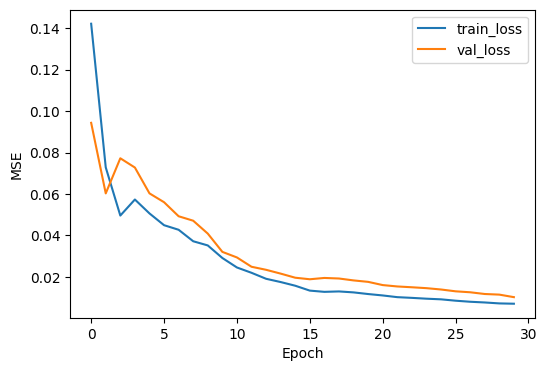

Seuil de reconstruction : 0.082149
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
Accuracy : 0.4057649667405765
Precision: 1.0
Recall   : 0.2776280323450135
F1-score : 0.4345991561181435


In [17]:
# 1) Plot train vs val loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.show()

# 2) Définition du seuil (mean + 2*std du train loss)
train_mse = np.array(history.history['loss'])
threshold = train_mse.mean() + 2*train_mse.std()
print(f"Seuil de reconstruction : {threshold:.6f}")

# 3) Évaluation binaire
# Charger toutes les images anormales
anom_dirs = [d for d in os.listdir(DATA_DIR) if d!='Healthy Potatoes']
anom_imgs = np.vstack([ load_images_from_folder(os.path.join(DATA_DIR,d)) for d in anom_dirs ])
# Labels et données
X = np.vstack([ normal_images, anom_imgs ])
y = np.hstack([ np.zeros(len(normal_images)), np.ones(len(anom_imgs)) ])
# Reconstruction et MSE
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)
# Metrics
print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

In [18]:
# --- Calcul du threshold sur chaque image normale ---
# 1) MSE par image sur le train
Xn_pred = ae.predict(normal_images)
mse_train = np.mean((normal_images - Xn_pred)**2, axis=(1,2,3))

# 2) Seuil au 95ᵉ percentile
threshold = np.percentile(mse_train, 95)
print(f"Seuil 95pct MSE_train = {threshold:.6f}")

# 3) Réévaluation binaire
# (on réutilise anom_imgs, X, y de la cellule précédente)
X_pred = ae.predict(X)
mse = np.mean((X - X_pred)**2, axis=(1,2,3))
y_pred = (mse > threshold).astype(int)

print("Accuracy :", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall   :", recall_score(y, y_pred))
print("F1-score :", f1_score(y, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Seuil 95pct MSE_train = 0.018356
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
Accuracy : 0.9379157427937915
Precision: 0.9886039886039886
Recall   : 0.9353099730458221
F1-score : 0.961218836565097


# Explication de la variation des métriques

- Avec `threshold = train_mse.mean() + 2*train_mse.std()`, on fixe un seuil souvent **trop élevé** : on ne classifie qu’une poignée d’images comme anomalies, d’où  
  - une **précision** très élevée (1.0) car on ne sort que des vrais positifs  
  - un **recall** très faible (beaucoup de faux négatifs)

- Avec `threshold = np.percentile(mse_train, 95)`, le seuil est plus **bas** et adapté à la distribution réelle des MSE sur les images normales.  
  - On détecte plus d’anomalies → **recall** monte  
  - L’**accuracy** globale s’améliore (on équilibre mieux faux positifs et faux négatifs)

Pour affiner encore, on peut tracer l’histogramme des MSE et positionner les seuils :


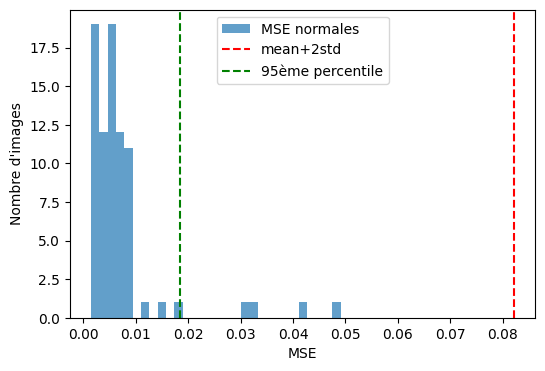

In [19]:
# Visualisation des distributions de MSE et comparaison des seuils
plt.figure(figsize=(6,4))
plt.hist(mse_train, bins=30, alpha=0.7, label='MSE normales')
seuil_std = history_threshold = train_mse.mean() + 2*train_mse.std()
seuil_pct = np.percentile(mse_train, 95)
plt.axvline(seuil_std, color='r', linestyle='--', label='mean+2std')
plt.axvline(seuil_pct, color='g', linestyle='--', label='95ème percentile')
plt.xlabel('MSE'); plt.ylabel('Nombre d\'images'); plt.legend(); plt.show()

In [13]:
# --- Partie 2: Classification Multi‑Classe — Option 1 : Multi‑Seuils Adaptatifs ---

# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Calculer le seuil (95e pct) de la reconstruction pour chaque classe
thresholds = []
for idx, d in enumerate(class_dirs):
    Xc = imgs_list[idx]
    Xc_pred = ae.predict(Xc)
    mse_c = np.mean((Xc - Xc_pred)**2, axis=(1,2,3))
    th = np.percentile(mse_c, 95)
    thresholds.append(th)
    print(f"Seuil 95pct MSE_train pour '{d}' = {th:.6f}")

# 3) Classifier chaque image par la classe dont (seuil - mse) est maximal
X_all_pred = ae.predict(X_all)
mse_all = np.mean((X_all - X_all_pred)**2, axis=(1,2,3))
thresholds_arr = np.array(thresholds)
diff = np.abs(mse_all[None, :] - thresholds_arr[:, None])  # k x n
y_pred_thresh = np.argmin(diff, axis=0)

# 4) Évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Multi‑Seuils Adaptatifs – Acc: %.3f  Préc: %.3f  Rcl: %.3f  F1: %.3f" %
      (accuracy_score(y_all, y_pred_thresh),
       precision_score(y_all, y_pred_thresh, average='macro'),
       recall_score(y_all, y_pred_thresh, average='macro'),
       f1_score(y_all, y_pred_thresh, average='macro')))
print("\nClassification report :\n", classification_report(y_all, y_pred_thresh, target_names=class_dirs))
print("Matrice de confusion :\n", confusion_matrix(y_all, y_pred_thresh))

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Seuil 95pct MSE_train pour 'Black Scurf' = 0.112636
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Seuil 95pct MSE_train pour 'Blackleg' = 0.146677
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Seuil 95pct MSE_train pour 'Common Scab' = 0.124852
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Seuil 95pct MSE_train pour 'Dry Rot' = 0.157084
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Seuil 95pct MSE_train pour 'Healthy Potatoes' = 0.018356
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Seuil 95pct MSE_train pour 'Miscellaneous' = 0.143315
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Seuil 95pct MSE_train pour 'Pink Rot' = 0.135204
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
Multi‑Seuils Adaptatifs – Acc: 0.228  Préc: 0.286  Rcl: 0.198  F1: 0.129

Classification report :
                   precision    recall  f1-score   support

     Black Scurf       0.12      0

Classes : ['Black Scurf', 'Blackleg', 'Common Scab', 'Dry Rot', 'Healthy Potatoes', 'Miscellaneous', 'Pink Rot'] | total images: 451
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
ARI : 0.17014290183375905
Silhouette : 0.0995235


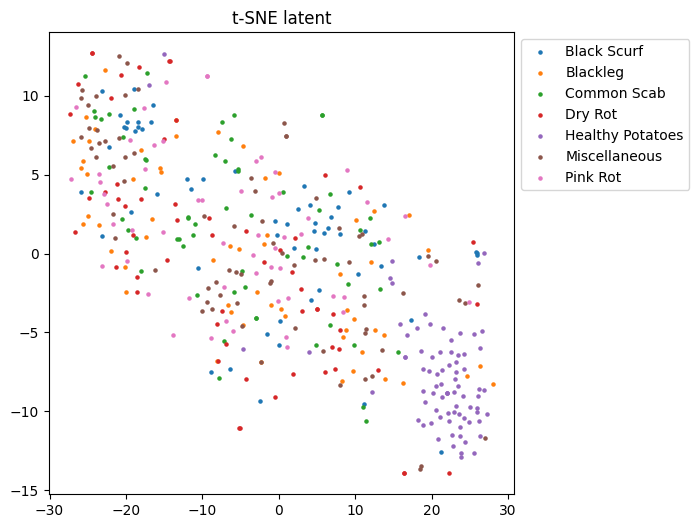

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


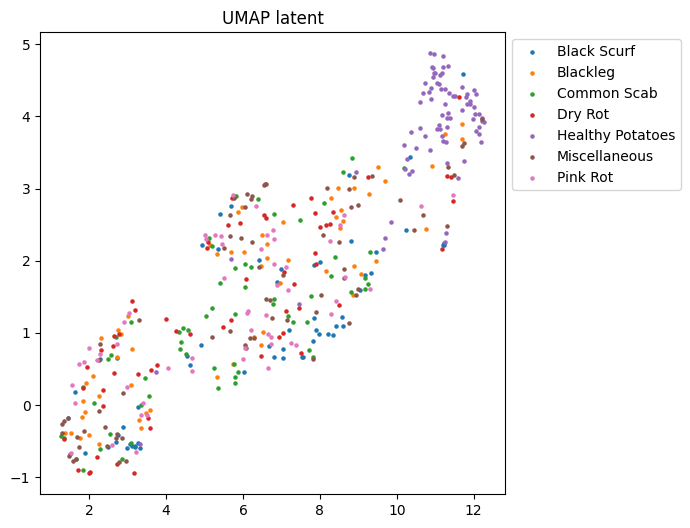

In [14]:
# --- Partie 2 : Clustering dans l’espace latent ---
# 1) Charger toutes les classes et labels
class_dirs = sorted(os.listdir(DATA_DIR))
imgs_list, y_list = [], []
for idx, d in enumerate(class_dirs):
    folder = os.path.join(DATA_DIR, d)
    arr = load_images_from_folder(folder)
    imgs_list.append(arr)
    y_list += [idx] * len(arr)
X_all = np.vstack(imgs_list)
y_all = np.array(y_list)
print("Classes :", class_dirs, "| total images:", X_all.shape[0])

# 2) Extraire le code latent via l’encodeur du CAE
encoder = tf.keras.Model(ae.input, ae.layers[4].output)
latent = encoder.predict(X_all)
latent_flat = latent.reshape(latent.shape[0], -1)

# 3) K‑means + métriques
n_clusters = len(class_dirs)
km = KMeans(n_clusters=n_clusters, random_state=42)
y_pred_km = km.fit_predict(latent_flat)
print("ARI :", adjusted_rand_score(y_all, y_pred_km))
print("Silhouette :", silhouette_score(latent_flat, y_pred_km))

# 4) Visualisation t‑SNE & UMAP
z_tsne = TSNE(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(z_tsne[idx,0], z_tsne[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("t-SNE latent"); plt.show()

umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(latent_flat)
plt.figure(figsize=(6,6))
for i, cname in enumerate(class_dirs):
    idx = y_all==i
    plt.scatter(umap_proj[idx,0], umap_proj[idx,1], s=5, label=cname)
plt.legend(bbox_to_anchor=(1,1)); plt.title("UMAP latent"); plt.show()

In [15]:
# --- Bonus 1: PCA + IsolationForest (détection d’anomalies) ---
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# 1) Flatten pour PCA et IsolationForest
X_flat = X.reshape(X.shape[0], -1)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_flat)

iso = IsolationForest(contamination=len(normal_images)/len(X), random_state=42)
y_iso = iso.fit_predict(X_pca)
# IsolationForest : -1=anomalie, 1=inlier → on convertit
y_pred_if = (y_iso == -1).astype(int)

print("PCA+IF  – Acc:", accuracy_score(y, y_pred_if),
      "Préc:", precision_score(y, y_pred_if),
      "Rec:", recall_score(y, y_pred_if),
      "F1:", f1_score(y, y_pred_if))

# --- Bonus 2: Classification supervisée sur l’espace latent (SVM & RF) ---
# On réutilise latent_flat et y_all
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    latent_flat, y_all, test_size=0.2, random_state=42, stratify=y_all)

for name, clf in [("SVM", SVC()), ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))]:
    clf.fit(X_train_l, y_train_l)
    y_pred_l = clf.predict(X_test_l)
    print(f"{name} – Acc: {accuracy_score(y_test_l,y_pred_l):.3f}, "
          f"Prc: {precision_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"Rcl: {recall_score(y_test_l,y_pred_l, average='macro'):.3f}, "
          f"F1: {f1_score(y_test_l,y_pred_l, average='macro'):.3f}")

PCA+IF  – Acc: 0.3370288248337029 Préc: 0.95 Rec: 0.20485175202156333 F1: 0.3370288248337029
SVM – Acc: 0.385, Prc: 0.316, Rcl: 0.347, F1: 0.310
RandomForest – Acc: 0.516, Prc: 0.500, Rcl: 0.488, F1: 0.479
